In [1]:
import pandas as pd
import math
import ast
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import seaborn as sns
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, ColumnDataSource, Range1d

%matplotlib inline
output_notebook()

tweets = pd.read_csv('../tweets/tweets_clean.csv',
                     header=0,
                     parse_dates=['date'])

Loading BokehJS ...

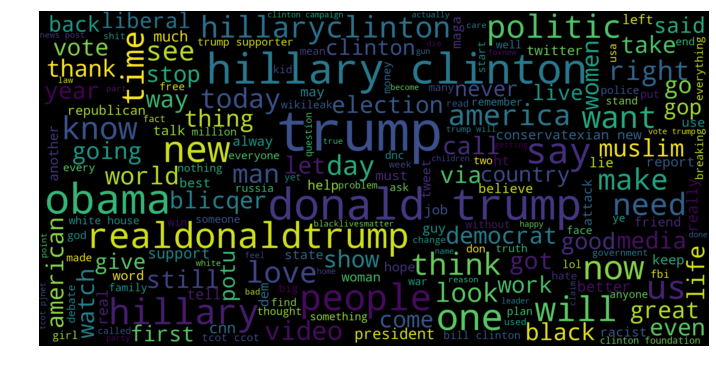

In [3]:
# Generate word cloud
tweet_text = tweets.clean_text.str.cat(sep=' ')
wordcloud = WordCloud(width=1600,
                      height=800,
                      max_font_size=200).generate(tweet_text)
fig = plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

fig.savefig('../visuals/wordcloud.png')

plt.show()

In [4]:
# Group into number of tweets per month
monthly_tweets = tweets.groupby([tweets.date.dt.year, tweets.date.dt.month]).size().to_frame('counts')
monthly_tweets.index.rename(['year', 'month'], inplace=True)

# Collapse index back into a single date
monthly_tweets.reset_index(inplace=True)
monthly_tweets['date'] = pd.to_datetime(dict(year=monthly_tweets.year,
                                             month=monthly_tweets.month,
                                             day=[1] * len(monthly_tweets)))
monthly_tweets.set_index(monthly_tweets['date'], inplace=True)
monthly_tweets.drop(['year', 'month', 'date'], axis=1, inplace=True)

In [7]:
def monthly_counts(tweets_df):
    # Create color palette for tweet values
    palette = sns.color_palette('YlOrRd', len(tweets_df))
    # Assign a color to each value of tweets by rank
    tweets_df['color'] = [mc.rgb2hex(palette[int(rank - 1)]) for rank in tweets_df.counts.rank()]

    src = ColumnDataSource(data=dict(date=tweets_df.index.values,
                                     counts=tweets_df.counts,
                                     color=tweets_df.color))

    p = figure(width=950, height=600,
               x_axis_type='datetime',
               x_axis_label='Date',
               y_axis_label='Number of tweets',
               title='Tweets per month')

    p.line(x='date',
           y='counts',
           line_width=4,
           color='lightgray',
           source=src)
    p.circle(x='date',
             y='counts',
             fill_color='color',
             size=15,
             source=src)

    hover = HoverTool(tooltips=[('Date', '@date{%B-%Y}'),
                                ('Num tweets', '@counts')],
                      formatters={'date': 'datetime'},
                      mode='vline')
    p.add_tools(hover)
    p.xgrid.grid_line_color = None

    return p

In [8]:
monthly_plot = monthly_counts(monthly_tweets)
show(monthly_plot)

In [9]:
# Group subset of tweets between July-2016 and March-2017
tweets_subset = tweets.set_index('date').loc['2016-07-01': '2017-03-31']
daily_tweets = tweets_subset.groupby(tweets_subset.index.date).size().to_frame('counts')

In [10]:
def daily_counts(tweets_df):
    # Create color palette for tweet values
    palette = sns.color_palette('YlOrRd', len(tweets_df))
    # Assign a color to each value of tweets by rank
    tweets_df['color'] = [mc.rgb2hex(palette[int(rank - 1)]) for rank in tweets_df.counts.rank()]

    src = ColumnDataSource(data=dict(date=tweets_df.index.values,
                                     counts=tweets_df.counts,
                                     color=tweets_df.color))

    p = figure(width=950, height=600,
               x_axis_type='datetime',
               x_axis_label='Date',
               y_axis_label='Number of tweets',
               title='Tweets per day')

    p.line(x='date',
           y='counts',
           line_width=4,
           color='lightgray',
           source=src)
    p.circle(x='date',
             y='counts',
             fill_color='color',
             size=12,
             source=src)

    hover = HoverTool(tooltips=[('Date', '@date{%m-%d-%Y}'),
                                ('Num tweets', '@counts')],
                      formatters={'date': 'datetime'},
                      mode='mouse')
    p.add_tools(hover)
    p.xgrid.grid_line_color = None

    return p

In [11]:
daily_plot = daily_counts(daily_tweets)
show(daily_plot)

In [12]:
# Group into user keys
user_tweets = tweets.groupby('user_key').size().sort_values(ascending=False).to_frame('counts')

In [17]:
def user_counts(tweets_df, num_users=20):
    users_to_plot = tweets_df.iloc[:num_users, :]

    palette = [mc.rgb2hex(col) for col in sns.color_palette('Blues_r', num_users)]

    src = ColumnDataSource(data=dict(user=users_to_plot.index.values,
                                     counts=users_to_plot.counts.values,
                                     color=palette))

    p = figure(plot_width=950, plot_height=600,
               x_range=users_to_plot.index.values,
               y_range=Range1d(0, max(tweets_df.counts) + 500),
               toolbar_location='above',
               x_axis_label='User',
               y_axis_label='Number of tweets',
               title='Tweets per user')
    p.vbar(x='user', top='counts',
           width=0.5,
           fill_color='color',
           source=src)

    hover = HoverTool(tooltips=[('User', '@user'),
                                ('Num tweets', '@counts')])
    p.add_tools(hover)
    p.xgrid.grid_line_color = None
    p.xaxis.major_label_orientation = math.pi / 4
    p.xaxis.major_label_text_font_size = "13pt"

    return p

In [18]:
user_plot = user_counts(user_tweets)
show(user_plot)

In [19]:
# Get a list of all hashtags from pandas column containing a list of hashtags per tweet
hashtags = [tag.lower() for tag_list in tweets.hashtags for tag in ast.literal_eval(tag_list)]

# Create df containing the counts of each hashtag
hashtag_df = pd.DataFrame.from_dict(Counter(hashtags),
                                    orient='index',
                                    columns=['counts']).sort_values(by='counts', ascending=False)

print('Number of unique hashtags:', len(set(hashtags)))

Number of unique hashtags: 21148


In [20]:
def hashtag_counts(tweets_df, num_hashtags=25):
    hashtags_to_plot = tweets_df.iloc[:num_hashtags, :]

    palette = [mc.rgb2hex(col) for col in sns.color_palette('Purples_r', num_hashtags)]

    src = ColumnDataSource(data=dict(hashtag=hashtags_to_plot.index.values,
                                     counts=hashtags_to_plot.counts.values,
                                     color=palette))

    p = figure(plot_width=950, plot_height=600,
               x_range=hashtags_to_plot.index.values,
               y_range=Range1d(0, max(tweets_df.counts) + 500),
               toolbar_location='above',
               x_axis_label='Hashtag',
               y_axis_label='Number of tweets',
               title='Tweets per hashtag')
    p.vbar(x='hashtag', top='counts',
           width=0.5,
           fill_color='color',
           source=src)

    hover = HoverTool(tooltips=[('Hashtag', '@hashtag'),
                                ('Num tweets', '@counts')])
    p.add_tools(hover)
    p.xgrid.grid_line_color = None
    p.xaxis.major_label_orientation = math.pi / 4
    p.xaxis.major_label_text_font_size = "14pt"

    return p

In [21]:
hashtag_plot = hashtag_counts(hashtag_df)
show(hashtag_plot)